In [2]:
import geopandas as gpd
import geemap, ee
import os

import shutil

import gdown
from random import randrange
import json
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show, adjust_band

from model.model import UNet
from scripts.raster_preparation import clip_raster, get_raster_mask, build_grid, clip_to_patches, build_mask_patches, get_vector_mask
from scripts.get_raster_data import SEN2_downloader
import torch
from tqdm import tqdm

%load_ext autoreload
%autoreload 2


In [10]:
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [3]:

model = UNet()
model.load_state_dict(torch.load("./model/model_state.pt"))

<All keys matched successfully>

In [4]:
regions = gpd.read_file('data/vector_data_stavropol.gpkg', layer = 'disctrict_boundary').to_crs('EPSG:32638')

In [6]:
regions['file_name'] = regions["NAME_EN"].str.split(expand = True)[0]

In [7]:
geoms_to_segmentate = regions[~regions['file_name'].isnull()][['file_name', 'geometry']]


In [8]:
regions_name = geoms_to_segmentate.file_name.unique()

In [15]:
rater = rasterio.open('./data/input_raster/Mineralovodsky.tif')

In [17]:
with rasterio.open('./data/input_raster/Mineralovodsky.tif', 'r+') as rds:
    print(rds.crs)


EPSG:32637


In [20]:
regions_name[1]

'Mineralovodsky'

In [26]:
for region_name in tqdm([regions_name[1]]): # убрать костыль
    sample_region = geoms_to_segmentate[geoms_to_segmentate['file_name'] == region_name]

    bufered_region = sample_region.copy()
    bufered_region.geometry = (sample_region.buffer(1500))





    if not os.path.exists(f'./data/input_raster/{region_name}.tif'):
        get_data = SEN2_downloader('2022', bufered_region) #здесь мы будем скачивать данные с небольшим запасом - создав буфер к нашему вектору по 500 метров
        get_data.get_collection()
        geemap.download_ee_image(get_data.rgb_nir, f'./data/input_raster/{region_name}.tif', region = geemap.geopandas_to_ee(bufered_region).geometry())
        print('скачивание закончено ')
    else:
        print('file exists')

    with rasterio.open(f'./data/input_raster/{region_name}.tif', 'r+') as rds:
        raster_crs = (rds.crs)



    sample_region = sample_region.to_crs(raster_crs)
    bufered_region = bufered_region.to_crs(raster_crs)
    grid = build_grid(bufered_region, 2560, 400)

    clip_to_patches(f'./data/input_raster/{region_name}.tif',grid)


    result = get_vector_mask("./data/temp/patches_meta.json", model, bufered_region)
    result = result.clip(sample_region)


    result.to_file(f'./data/output_vector/{region_name}.geojson', driver = 'GeoJSON')

    #shutil.rmtree("./data/temp/classified_patches")
    #shutil.rmtree("./data/temp/raster_patches")
    #os.remove("./data/temp/patches_meta.json")

  0%|          | 0/1 [00:00<?, ?it/s]

Mineralovodsky.tif: |          | 0.00/993M (raw) [  0.0%] in 00:00 (eta:     ?)

скачивание закончено 


100%|██████████| 445/445 [00:22<00:00, 19.81it/s]


применение сети для сегментации...


100%|██████████| 445/445 [00:53<00:00,  8.30it/s]


собираем общий растр...


100%|██████████| 445/445 [00:02<00:00, 166.73it/s]
/home/geotrojan/.local/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
100%|██████████| 1/1 [05:11<00:00, 311.62s/it]


In [27]:
shutil.rmtree("./data/temp/raster_patches")
os.remove("./data/temp/patches_meta.json")
shutil.rmtree("./data/temp/classified_patches")



In [24]:
clip_to_patches(f'./data/input_raster/{regions_name[0]}.tif',grid)


100%|██████████| 571/571 [00:21<00:00, 26.37it/s]


In [25]:
result = get_vector_mask("./data/temp/patches_meta.json", model, bufered_region)
result = result.clip(sample_region).plot()


применение сети для сегментации...


100%|██████████| 571/571 [01:00<00:00,  9.51it/s]


собираем общий растр...


100%|██████████| 571/571 [00:01<00:00, 313.23it/s]


<AxesSubplot:>

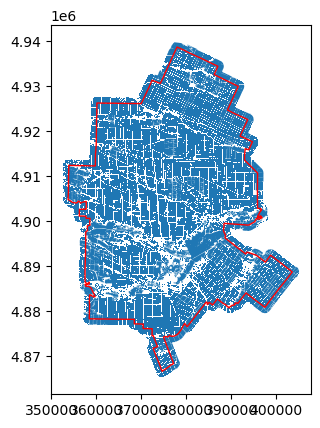

In [27]:
ax = result.plot()
sample_region.plot(facecolor='none' ,edgecolor = 'r', ax = ax)

/home/geotrojan/.local/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


<AxesSubplot:>

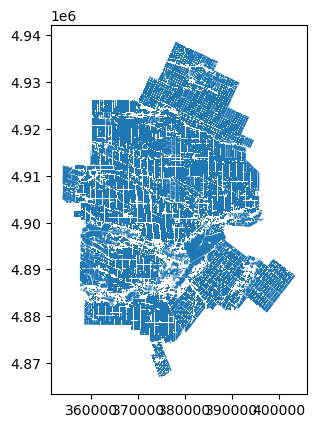

In [29]:
result.clip(sample_region).plot()

<AxesSubplot:>

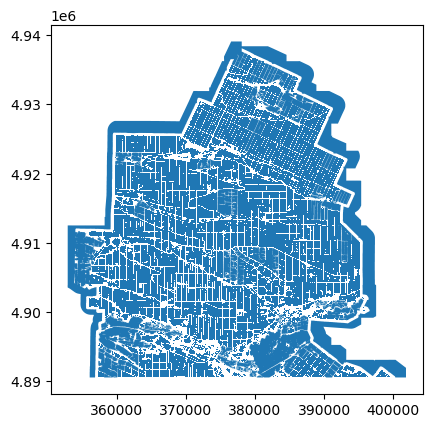

In [23]:
result.to_file(f'./data/output_vector/{regions_name[0]}.geojson', driver = 'GeoJSON')
result.plot()

<AxesSubplot:>

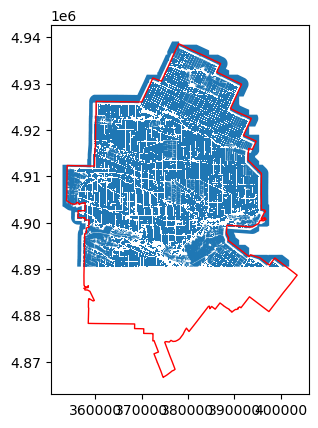

In [81]:
ax = result.plot()
sample_region.plot(facecolor='none' ,edgecolor = 'r', ax = ax)
